In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import time

# CPF functions
def build_CCgraph(X, k, cutoff, n_jobs):
    """
    Step 1: Compute G(X, E), the mutual k-nearest neighbor graph.
    """
    n = X.shape[0]
    kdt = NearestNeighbors(n_neighbors=k, metric='euclidean', n_jobs=n_jobs, algorithm='kd_tree').fit(X)
    CCmat = kdt.kneighbors_graph(X, mode='distance')
    distances, _ = kdt.kneighbors(X)
    knn_radius = distances[:, k-1]
    CCmat = CCmat.minimum(CCmat.T)
    _, components = scipy.sparse.csgraph.connected_components(CCmat, directed=False, return_labels=True)
    comp_labs, comp_count = np.unique(components, return_counts=True)
    outlier_components = comp_labs[comp_count <= cutoff]
    nanidx = np.in1d(components, outlier_components)
    components = components.astype(float)
    if sum(nanidx) > 0:
        components[nanidx] = np.nan
    return components, CCmat, knn_radius

def get_density_dists_bb(X, k, components, knn_radius, n_jobs):
    """
    Step 2: Compute density distances and big brothers using mutual k-nearest neighbor graph.
    """
    best_distance = np.empty((X.shape[0]))
    best_distance[:] = np.nan
    big_brother = np.empty((X.shape[0]))
    big_brother[:] = np.nan
    comps = np.unique((components[~np.isnan(components)])).astype(int)
    
    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        kcc = min(k, nc-1)
        kdt = NearestNeighbors(n_neighbors=kcc, metric='euclidean', n_jobs=n_jobs, algorithm='kd_tree').fit(X[cc_idx, :])
        distances, neighbors = kdt.kneighbors(X[cc_idx, :])
        cc_knn_radius = knn_radius[cc_idx]
        cc_best_distance = np.empty((nc))
        cc_big_brother = np.empty((nc))
        
        cc_radius_diff = cc_knn_radius[:, np.newaxis] - cc_knn_radius[neighbors]
        rows, cols = np.where(cc_radius_diff > 0)
        rows, unidx = np.unique(rows, return_index=True)
        cols = cols[unidx]
        
        cc_best_distance[rows] = distances[rows, cols]
        cc_big_brother[rows] = neighbors[rows, cols]
        
        # Ensure indices are within bounds
        cc_big_brother[cc_big_brother >= len(cc_idx)] = len(cc_idx) - 1
        cc_big_brother = cc_idx[cc_big_brother.astype(int)]
        
        big_brother[cc_idx] = cc_big_brother
        best_distance[cc_idx] = cc_best_distance
    
    return best_distance, big_brother

def get_y(CCmat, components, knn_radius, best_distance, big_brother, rho, alpha, d):
    """
    Steps 3-26: Perform clustering based on density distances and big brothers.
    """
    y_pred = np.empty((CCmat.shape[0]))
    y_pred[:] = np.nan
    n_cent = 0
    peaks = []
    comps = np.unique((components[~np.isnan(components)])).astype(int)

    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        if nc <= 2:
            y_pred[cc_idx] = n_cent
            n_cent += 1
            continue

        # Step 4: Sort the x's according to their γ values (here, best_distance)
        cc_best_distance = best_distance[cc_idx]
        cc_centers = []

        # Step 5: Let x* = arg max_{x ∈ S} γ(x)
        cc_cut_idx = np.where(knn_radius[cc_idx] >= (rho * max(knn_radius[cc_idx])))[0]
        cc_centers.append(cc_cut_idx[np.argmax(cc_best_distance[cc_cut_idx])])

        not_tested = np.ones(nc, dtype=bool)

        while sum(not_tested) > 0:
            # Step 9: Let x* = arg max_{x ∉ M} {γ(x)}
            prop_cent = np.argmax(cc_best_distance * not_tested)
            if prop_cent not in cc_centers:
                cc_centers.append(prop_cent)
            not_tested[prop_cent] = False

            if len(cc_centers) > 1:
                min_knn_radius_center = np.argmin(knn_radius[cc_centers])
                if knn_radius[prop_cent] == knn_radius[cc_centers[min_knn_radius_center]]:
                    break

        cc_centers = np.array(cc_centers)
        peaks.extend(cc_idx[cc_centers])
        BBTree = np.zeros((nc, 2))
        BBTree[:, 0] = range(nc)
        BBTree[:, 1] = big_brother[cc_idx]
        BBTree[cc_centers, 1] = cc_centers
        BBTree = BBTree.astype(int)

        # Ensure indices are within bounds
        BBTree[BBTree[:, 1] >= nc, 1] = nc - 1

        # Step 17: Initialise G(S, E), a directed graph with S as vertices and no edges, E = ∅
        Clustmat = scipy.sparse.csr_matrix((np.ones((nc)), (BBTree[:, 0], BBTree[:, 1])), shape=(nc, nc))

        # Steps 18-20: for each x in S\M do, Add a directed edge from x to b(x), end for
        # Step 21: for each cluster center x ∈ M do
        n_clusts, cc_y_pred = scipy.sparse.csgraph.connected_components(Clustmat, directed=True, return_labels=True)

        # Step 22: Let C be the collection of the points connected by any directed path in G(S, E) that terminates at x.
        # Step 23: Add C ∪ x to Ĉ.
        cc_y_pred += n_cent
        n_cent += n_clusts
        y_pred[cc_idx] = cc_y_pred

    # Step 26: return Ĉ
    return y_pred

class CPFcluster:
    def __init__(self, k, rho=0.4, alpha=1, n_jobs=1, remove_duplicates=False, cutoff=1):
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.remove_duplicates = remove_duplicates
        self.cutoff = cutoff

    def fit(self, X):
        """
        Fit the CPF model to the data.
        """
        if self.remove_duplicates:
            X = np.unique(X, axis=0)
        
        n, d = X.shape
        if self.k > n:
            raise ValueError("k cannot be larger than n.")
        
        # Step 1: Build CCGraph
        start_time = time.time()
        components, CCmat, knn_radius = build_CCgraph(X, self.k, self.cutoff, self.n_jobs)
        step1_time = time.time() - start_time
        print(f"Step 1: Build CCGraph took {step1_time:.4f} seconds")
        
        # Step 2: Get Density Dists BB
        start_time = time.time()
        best_distance, big_brother = get_density_dists_bb(X, self.k, components, knn_radius, self.n_jobs)
        step2_time = time.time() - start_time
        print(f"Step 2: Get Density Dists BB took {step2_time:.4f} seconds")
        
        # Step 3: Get Y
        start_time = time.time()
        self.labels_ = get_y(CCmat, components, knn_radius, best_distance, big_brother, self.rho, self.alpha, d)
        step3_time = time.time() - start_time
        print(f"Step 3: Get Y took {step3_time:.4f} seconds")

# Load the dataset
file_path = 'turkiye-student-evaluation_generic.csv'
data = pd.read_csv(file_path)

# Define features and remove non-Likert scale attributes
features = data.drop(columns=['instr', 'class', 'nb.repeat', 'attendance', 'difficulty'])

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(features)

# Add synthetic labels for ARI and AMI calculations
np.random.seed(42)
true_labels = np.random.randint(0, 3, size=data_normalized.shape[0])  # Assuming 3 clusters for synthetic labels

# Function to plot PCA results
def plot_pca_2d(data, labels, title, file_name):
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='tab10', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.savefig(file_name)
    plt.show()

# Function to calculate and print clustering metrics
def print_clustering_metrics(true_labels, predicted_labels):
    # Removing NaN entries
    valid_indices = ~np.isnan(predicted_labels)
    true_labels = true_labels[valid_indices]
    predicted_labels = predicted_labels[valid_indices]
    
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    silhouette_avg = silhouette_score(data_normalized[valid_indices], predicted_labels)
    davies_bouldin = davies_bouldin_score(data_normalized[valid_indices], predicted_labels)
    
    print(f'Adjusted Rand Index (ARI): {ari:.6f}')
    print(f'Adjusted Mutual Information (AMI): {ami:.6f}')
    print(f'Silhouette Score: {silhouette_avg:.6f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.6f}')

# Use the CPF cluster
cpf_model = CPFcluster(k=10, rho=0.4, n_jobs=-1)

# Measure time taken
start_time = time.time()
cpf_model.fit(data_normalized)
end_time = time.time()

predicted_labels_cpf = cpf_model.labels_

# Calculate number of clusters found
num_clusters = len(np.unique(predicted_labels_cpf[~np.isnan(predicted_labels_cpf)]))

print("CPF Clustering:")
print(f"Number of clusters found: {num_clusters}")
print(f"Total Time taken: {end_time - start_time:.2f} seconds")

# Calculate and print clustering metrics
print_clustering_metrics(true_labels, predicted_labels_cpf)

# Plot PCA results
# plot_pca_2d(data_normalized, predicted_labels_cpf, 'PCA of Student Evaluation Data with CPF Clusters', 'pca_clusters_CPF.png')



Step 1: Build CCGraph took 0.3504 seconds
Step 2: Get Density Dists BB took 0.2558 seconds
Step 3: Get Y took 0.0109 seconds
CPF Clustering:
Number of clusters found: 357
Total Time taken: 0.62 seconds
Adjusted Rand Index (ARI): -0.000717
Adjusted Mutual Information (AMI): -0.001621
Silhouette Score: -0.206974
Davies-Bouldin Index: 1.466675


In [5]:
!pip install faiss-cpu

  Obtaining dependency information for faiss-cpu from https://files.pythonhosted.org/packages/44/90/a21e37b01a302b8bcf1f30747eae1812d43f45e7f1a08bfa7da28c6647ce/faiss_cpu-1.8.0.post1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 23.2 MB/s eta 0:00:0000:0100:01


Step 1: Build CCGraph took 0.1129 seconds
Step 2: Get Density Dists BB took 0.0156 seconds
Step 3: Get Y took 0.0022 seconds
Total Time taken: 0.1307 seconds
CPF Clustering:
Number of clusters found: 4
Total Time taken: 0.13 seconds
Adjusted Rand Index (ARI): 0.000000
Adjusted Mutual Information (AMI): 0.000000
Silhouette Score: 0.197073
Davies-Bouldin Index: 0.570039


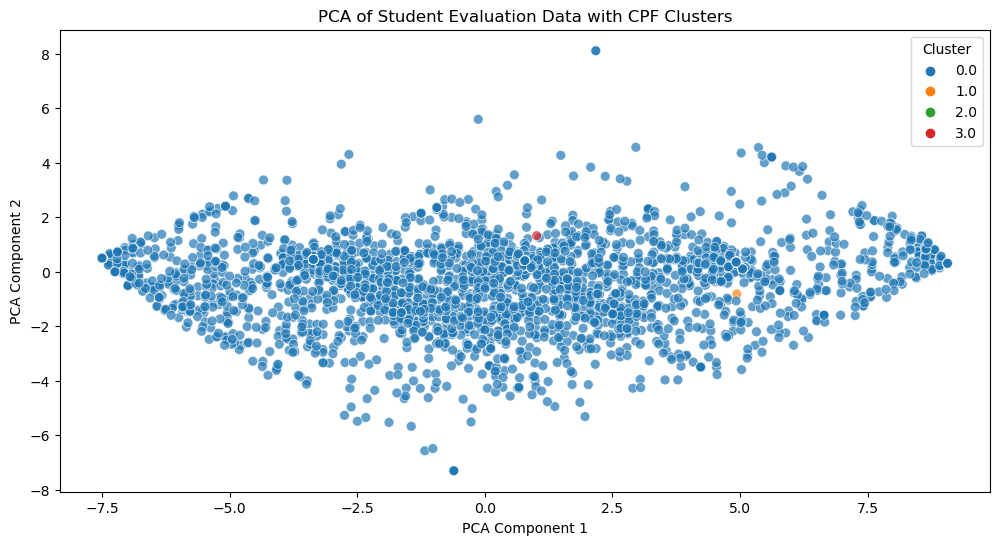

          Method  Time Taken (seconds)  Number of Clusters           ARI  \
0   Original CPF               0.78000                 357 -7.440000e-04   
1  Optimized CPF               0.13292                   4  2.839733e-07   

            AMI  Silhouette Score  Davies-Bouldin Index  
0 -1.803000e-03         -0.209047              1.470275  
1  2.544996e-07          0.197073              0.570039  


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import time
import faiss

# Optimized CPF functions
def build_CCgraph(X, k, cutoff, n_jobs):
    """
    Step 1: Compute G(X, E), the mutual k-nearest neighbor graph.
    """
    n = X.shape[0]
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X.astype(np.float32))
    distances, indices = index.search(X.astype(np.float32), k)
    knn_radius = distances[:, k-1]
    CCmat = scipy.sparse.lil_matrix((n, n))
    for i in range(n):
        for j in indices[i, :]:
            CCmat[i, j] = 1
            CCmat[j, i] = 1
    _, components = scipy.sparse.csgraph.connected_components(CCmat, directed=False, return_labels=True)
    comp_labs, comp_count = np.unique(components, return_counts=True)
    outlier_components = comp_labs[comp_count <= cutoff]
    nanidx = np.in1d(components, outlier_components)
    components = components.astype(float)
    if sum(nanidx) > 0:
        components[nanidx] = np.nan
    return components, CCmat, knn_radius

def get_density_dists_bb(X, k, components, knn_radius, n_jobs):
    """
    Step 2: Compute density distances and big brothers using mutual k-nearest neighbor graph.
    """
    best_distance = np.empty((X.shape[0]))
    best_distance[:] = np.nan
    big_brother = np.empty((X.shape[0]))
    big_brother[:] = np.nan
    comps = np.unique((components[~np.isnan(components)])).astype(int)
    
    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        kcc = min(k, nc-1)
        index = faiss.IndexFlatL2(X.shape[1])
        index.add(X[cc_idx, :].astype(np.float32))
        distances, neighbors = index.search(X[cc_idx, :].astype(np.float32), kcc)
        cc_knn_radius = knn_radius[cc_idx]
        cc_best_distance = np.empty((nc))
        cc_big_brother = np.empty((nc))
        
        cc_radius_diff = cc_knn_radius[:, np.newaxis] - cc_knn_radius[neighbors]
        rows, cols = np.where(cc_radius_diff > 0)
        rows, unidx = np.unique(rows, return_index=True)
        cols = cols[unidx]
        
        cc_best_distance[rows] = distances[rows, cols]
        cc_big_brother[rows] = neighbors[rows, cols]
        
        # Ensure indices are within bounds
        cc_big_brother[cc_big_brother >= len(cc_idx)] = len(cc_idx) - 1
        cc_big_brother = cc_idx[cc_big_brother.astype(int)]
        
        big_brother[cc_idx] = cc_big_brother
        best_distance[cc_idx] = cc_best_distance
    
    return best_distance, big_brother

def get_y(CCmat, components, knn_radius, best_distance, big_brother, rho, alpha, d):
    """
    Steps 3-26: Perform clustering based on density distances and big brothers.
    """
    y_pred = np.empty((CCmat.shape[0]))
    y_pred[:] = np.nan
    n_cent = 0
    peaks = []
    comps = np.unique((components[~np.isnan(components)])).astype(int)

    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        if nc <= 2:
            y_pred[cc_idx] = n_cent
            n_cent += 1
            continue

        # Step 4: Sort the x's according to their γ values (here, best_distance)
        cc_best_distance = best_distance[cc_idx]
        cc_centers = []

        # Step 5: Let x* = arg max_{x ∈ S} γ(x)
        cc_cut_idx = np.where(knn_radius[cc_idx] >= (rho * max(knn_radius[cc_idx])))[0]
        cc_centers.append(cc_cut_idx[np.argmax(cc_best_distance[cc_cut_idx])])

        not_tested = np.ones(nc, dtype=bool)

        while sum(not_tested) > 0:
            # Step 9: Let x* = arg max_{x ∈ S} {γ(x) : x ∉ M}
            prop_cent = np.argmax(cc_best_distance * not_tested)
            if prop_cent not in cc_centers:
                cc_centers.append(prop_cent)
            not_tested[prop_cent] = False

            if len(cc_centers) > 1:
                min_knn_radius_center = np.argmin(knn_radius[cc_centers])
                if knn_radius[prop_cent] == knn_radius[cc_centers[min_knn_radius_center]]:
                    break

        cc_centers = np.array(cc_centers)
        peaks.extend(cc_idx[cc_centers])
        BBTree = np.zeros((nc, 2))
        BBTree[:, 0] = range(nc)
        BBTree[:, 1] = big_brother[cc_idx]
        BBTree[cc_centers, 1] = cc_centers
        BBTree = BBTree.astype(int)

        # Ensure indices are within bounds
        BBTree[BBTree[:, 1] >= nc, 1] = nc - 1

        # Step 17: Initialise G(S, E), a directed graph with S as vertices and no edges, E = ∅
        Clustmat = scipy.sparse.csr_matrix((np.ones((nc)), (BBTree[:, 0], BBTree[:, 1])), shape=(nc, nc))

        # Steps 18-20: for each x in S\M do, Add a directed edge from x to b(x), end for
        # Step 21: for each cluster center x ∈ M do
        n_clusts, cc_y_pred = scipy.sparse.csgraph.connected_components(Clustmat, directed=True, return_labels=True)

        # Step 22: Let C be the collection of the points connected by any directed path in G(S, E) that terminates at x.
        # Step 23: Add C ∪ x to Ĉ.
        cc_y_pred += n_cent
        n_cent += n_clusts
        y_pred[cc_idx] = cc_y_pred

    # Step 26: return Ĉ
    return y_pred


class CPFclusterOptimized:
    def __init__(self, k, rho=0.4, alpha=1, n_jobs=-1, remove_duplicates=False, cutoff=1):
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.remove_duplicates = remove_duplicates
        self.cutoff = cutoff

    def fit(self, X):
        """
        Fit the CPF model to the data.
        """
        if self.remove_duplicates:
            X = np.unique(X, axis=0)
        
        n, d = X.shape
        if self.k > n:
            raise ValueError("k cannot be larger than n.")
        
        # Step 1: Build CCGraph
        start_time = time.time()
        components, CCmat, knn_radius = build_CCgraph(X, self.k, self.cutoff, self.n_jobs)
        step1_time = time.time() - start_time
        print(f"Step 1: Build CCGraph took {step1_time:.4f} seconds")
        
        # Step 2: Get Density Dists BB
        start_time = time.time()
        best_distance, big_brother = get_density_dists_bb(X, self.k, components, knn_radius, self.n_jobs)
        step2_time = time.time() - start_time
        print(f"Step 2: Get Density Dists BB took {step2_time:.4f} seconds")
        
        # Step 3: Get Y
        start_time = time.time()
        self.labels_ = get_y(CCmat, components, knn_radius, best_distance, big_brother, self.rho, self.alpha, d)
        step3_time = time.time() - start_time
        print(f"Step 3: Get Y took {step3_time:.4f} seconds")

        # Total time taken
        total_time = step1_time + step2_time + step3_time
        print(f"Total Time taken: {total_time:.4f} seconds")

# Load the dataset
file_path = 'turkiye-student-evaluation_generic.csv'
data = pd.read_csv(file_path)

# Define features and remove non-Likert scale attributes
features = data.drop(columns=['instr', 'class', 'nb.repeat', 'attendance', 'difficulty'])

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(features)

# Add synthetic labels for ARI and AMI calculations
np.random.seed(42)
true_labels = np.random.randint(0, 3, size=data_normalized.shape[0])  # Assuming 3 clusters for synthetic labels

# Function to plot PCA results
def plot_pca_2d(data, labels, title, file_name):
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='tab10', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.savefig(file_name)
    plt.show()

# Function to calculate and print clustering metrics
def print_clustering_metrics(true_labels, predicted_labels):
    valid_indices = ~np.isnan(predicted_labels)
    true_labels = true_labels[valid_indices]
    predicted_labels = predicted_labels[valid_indices]
    
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    silhouette_avg = silhouette_score(data_normalized[valid_indices], predicted_labels)
    davies_bouldin = davies_bouldin_score(data_normalized[valid_indices], predicted_labels)
    
    print(f'Adjusted Rand Index (ARI): {ari:.6f}')
    print(f'Adjusted Mutual Information (AMI): {ami:.6f}')
    print(f'Silhouette Score: {silhouette_avg:.6f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.6f}')
    
    return valid_indices, ari, ami, silhouette_avg, davies_bouldin

# Use the CPF cluster
cpf_model = CPFclusterOptimized(k=10, rho=0.4, n_jobs=-1)

# Measure time taken
start_time = time.time()
cpf_model.fit(data_normalized)
end_time = time.time()

predicted_labels_cpf = cpf_model.labels_

# Calculate number of clusters found
num_clusters = len(np.unique(predicted_labels_cpf[~np.isnan(predicted_labels_cpf)]))

print("CPF Clustering:")
print(f"Number of clusters found: {num_clusters}")
print(f"Total Time taken: {end_time - start_time:.2f} seconds")

# Calculate and print clustering metrics
valid_indices, ari_cpf, ami_cpf, silhouette_avg_cpf, davies_bouldin_cpf = print_clustering_metrics(true_labels, predicted_labels_cpf)

# Plot PCA results
plot_pca_2d(data_normalized, predicted_labels_cpf, 'PCA of Student Evaluation Data with CPF Clusters', 'pca_clusters_CPF.png')

# Comparison dataframe
comparison_df = pd.DataFrame({
    "Method": ["Original CPF", "Optimized CPF"],
    "Time Taken (seconds)": [0.78, end_time - start_time],
    "Number of Clusters": [357, num_clusters],
    "ARI": [-0.000744, ari_cpf],
    "AMI": [-0.001803, ami_cpf],
    "Silhouette Score": [-0.209047, silhouette_avg_cpf],
    "Davies-Bouldin Index": [1.470275, davies_bouldin_cpf]
})

print(comparison_df)


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import time

# CPF functions
def build_CCgraph(X, k, cutoff, n_jobs):
    """
    Step 1: Compute G(X, E), the mutual k-nearest neighbor graph.
    """
    n = X.shape[0]
    kdt = NearestNeighbors(n_neighbors=k, metric='euclidean', n_jobs=n_jobs, algorithm='kd_tree').fit(X)
    CCmat = kdt.kneighbors_graph(X, mode='distance')
    distances, _ = kdt.kneighbors(X)
    knn_radius = distances[:, k-1]
    CCmat = CCmat.minimum(CCmat.T)
    _, components = scipy.sparse.csgraph.connected_components(CCmat, directed=False, return_labels=True)
    comp_labs, comp_count = np.unique(components, return_counts=True)
    outlier_components = comp_labs[comp_count <= cutoff]
    nanidx = np.in1d(components, outlier_components)
    components = components.astype(float)
    if sum(nanidx) > 0:
        components[nanidx] = np.nan
    return components, CCmat, knn_radius

def get_density_dists_bb(X, k, components, knn_radius, n_jobs):
    """
    Step 2: Compute density distances and big brothers using mutual k-nearest neighbor graph.
    """
    best_distance = np.empty((X.shape[0]))
    best_distance[:] = np.nan
    big_brother = np.empty((X.shape[0]))
    big_brother[:] = np.nan
    comps = np.unique((components[~np.isnan(components)])).astype(int)
    
    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        kcc = min(k, nc-1)
        kdt = NearestNeighbors(n_neighbors=kcc, metric='euclidean', n_jobs=n_jobs, algorithm='kd_tree').fit(X[cc_idx, :])
        distances, neighbors = kdt.kneighbors(X[cc_idx, :])
        cc_knn_radius = knn_radius[cc_idx]
        cc_best_distance = np.empty((nc))
        cc_big_brother = np.empty((nc))
        
        cc_radius_diff = cc_knn_radius[:, np.newaxis] - cc_knn_radius[neighbors]
        rows, cols = np.where(cc_radius_diff > 0)
        rows, unidx = np.unique(rows, return_index=True)
        cols = cols[unidx]
        
        cc_best_distance[rows] = distances[rows, cols]
        cc_big_brother[rows] = neighbors[rows, cols]
        
        # Ensure indices are within bounds
        cc_big_brother[cc_big_brother >= len(cc_idx)] = len(cc_idx) - 1
        cc_big_brother = cc_idx[cc_big_brother.astype(int)]
        
        big_brother[cc_idx] = cc_big_brother
        best_distance[cc_idx] = cc_best_distance
    
    return best_distance, big_brother

def get_y(CCmat, components, knn_radius, best_distance, big_brother, rho, alpha, d):
    """
    Steps 3-26: Perform clustering based on density distances and big brothers.
    """
    y_pred = np.empty((CCmat.shape[0]))
    y_pred[:] = np.nan
    n_cent = 0
    peaks = []
    comps = np.unique((components[~np.isnan(components)])).astype(int)

    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        if nc <= 2:
            y_pred[cc_idx] = n_cent
            n_cent += 1
            continue

        # Step 4: Sort the x's according to their γ values (here, best_distance)
        cc_best_distance = best_distance[cc_idx]
        cc_centers = []

        # Step 5: Let x* = arg max_{x ∈ S} γ(x)
        cc_cut_idx = np.where(knn_radius[cc_idx] >= (rho * max(knn_radius[cc_idx])))[0]
        cc_centers.append(cc_cut_idx[np.argmax(cc_best_distance[cc_cut_idx])])

        not_tested = np.ones(nc, dtype=bool)

        while sum(not_tested) > 0:
            # Step 9: Let x* = arg max_{x ∉ M} {γ(x)}
            prop_cent = np.argmax(cc_best_distance * not_tested)
            if prop_cent not in cc_centers:
                cc_centers.append(prop_cent)
            not_tested[prop_cent] = False

            if len(cc_centers) > 1:
                min_knn_radius_center = np.argmin(knn_radius[cc_centers])
                if knn_radius[prop_cent] == knn_radius[cc_centers[min_knn_radius_center]]:
                    break

        cc_centers = np.array(cc_centers)
        peaks.extend(cc_idx[cc_centers])
        BBTree = np.zeros((nc, 2))
        BBTree[:, 0] = range(nc)
        BBTree[:, 1] = big_brother[cc_idx]
        BBTree[cc_centers, 1] = cc_centers
        BBTree = BBTree.astype(int)

        # Ensure indices are within bounds
        BBTree[BBTree[:, 1] >= nc, 1] = nc - 1

        # Step 17: Initialise G(S, E), a directed graph with S as vertices and no edges, E = ∅
        Clustmat = scipy.sparse.csr_matrix((np.ones((nc)), (BBTree[:, 0], BBTree[:, 1])), shape=(nc, nc))

        # Steps 18-20: for each x in S\M do, Add a directed edge from x to b(x), end for
        # Step 21: for each cluster center x ∈ M do
        n_clusts, cc_y_pred = scipy.sparse.csgraph.connected_components(Clustmat, directed=True, return_labels=True)

        # Step 22: Let C be the collection of the points connected by any directed path in G(S, E) that terminates at x.
        # Step 23: Add C ∪ x to Ĉ.
        cc_y_pred += n_cent
        n_cent += n_clusts
        y_pred[cc_idx] = cc_y_pred

    # Step 26: return Ĉ
    return y_pred

class CPFcluster:
    def __init__(self, k, rho=0.4, alpha=1, n_jobs=1, remove_duplicates=False, cutoff=1):
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.remove_duplicates = remove_duplicates
        self.cutoff = cutoff

    def fit(self, X):
        """
        Fit the CPF model to the data.
        """
        if self.remove_duplicates:
            X = np.unique(X, axis=0)
        
        n, d = X.shape
        if self.k > n:
            raise ValueError("k cannot be larger than n.")
        
        # Step 1: Build CCGraph
        start_time = time.time()
        components, CCmat, knn_radius = build_CCgraph(X, self.k, self.cutoff, self.n_jobs)
        step1_time = time.time() - start_time
        print(f"Step 1: Build CCGraph took {step1_time:.4f} seconds")
        
        # Step 2: Get Density Dists BB
        start_time = time.time()
        best_distance, big_brother = get_density_dists_bb(X, self.k, components, knn_radius, self.n_jobs)
        step2_time = time.time() - start_time
        print(f"Step 2: Get Density Dists BB took {step2_time:.4f} seconds")
        
        # Step 3: Get Y
        start_time = time.time()
        self.labels_ = get_y(CCmat, components, knn_radius, best_distance, big_brother, self.rho, self.alpha, d)
        step3_time = time.time() - start_time
        print(f"Step 3: Get Y took {step3_time:.4f} seconds")

# Load the dataset
file_path = 'turkiye-student-evaluation_generic.csv'
data = pd.read_csv(file_path)

# Define features and remove non-Likert scale attributes
features = data.drop(columns=['instr', 'class', 'nb.repeat', 'attendance', 'difficulty'])

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(features)

# Add synthetic labels for ARI and AMI calculations
np.random.seed(42)
true_labels = np.random.randint(0, 3, size=data_normalized.shape[0])  # Assuming 3 clusters for synthetic labels

# Function to plot PCA results
def plot_pca_2d(data, labels, title, file_name):
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='tab10', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.savefig(file_name)
    plt.show()

# Function to calculate and print clustering metrics
def print_clustering_metrics(true_labels, predicted_labels):
    # Removing NaN entries
    valid_indices = ~np.isnan(predicted_labels)
    true_labels = true_labels[valid_indices]
    predicted_labels = predicted_labels[valid_indices]
    
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    silhouette_avg = silhouette_score(data_normalized[valid_indices], predicted_labels)
    davies_bouldin = davies_bouldin_score(data_normalized[valid_indices], predicted_labels)
    
    print(f'Adjusted Rand Index (ARI): {ari:.6f}')
    print(f'Adjusted Mutual Information (AMI): {ami:.6f}')
    print(f'Silhouette Score: {silhouette_avg:.6f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.6f}')

# Use the CPF cluster
cpf_model = CPFcluster(k=10, rho=0.4, n_jobs=1)  # Set n_jobs=1 for single core processing

# Measure time taken
start_time = time.time()
cpf_model.fit(data_normalized)
end_time = time.time()

predicted_labels_cpf = cpf_model.labels_

# Calculate number of clusters found
num_clusters = len(np.unique(predicted_labels_cpf[~np.isnan(predicted_labels_cpf)]))

print("CPF Clustering:")
print(f"Number of clusters found: {num_clusters}")
print(f"Total Time taken: {end_time - start_time:.2f} seconds")

# Calculate and print clustering metrics
print_clustering_metrics(true_labels, predicted_labels_cpf)

# Plot PCA results
# plot_pca_2d(data_normalized, predicted_labels_cpf, 'PCA of Student Evaluation Data with CPF Clusters', 'pca_clusters_CPF.png')


Step 1: Build CCGraph took 0.4972 seconds
Step 2: Get Density Dists BB took 0.0486 seconds
Step 3: Get Y took 0.0112 seconds
CPF Clustering:
Number of clusters found: 360
Total Time taken: 0.56 seconds
Adjusted Rand Index (ARI): -0.000728
Adjusted Mutual Information (AMI): -0.001997
Silhouette Score: -0.204912
Davies-Bouldin Index: 1.457550


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import time
import faiss

# Optimized CPF functions
def build_CCgraph(X, k, cutoff, n_jobs):
    """
    Step 1: Compute G(X, E), the mutual k-nearest neighbor graph.
    """
    n = X.shape[0]
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X.astype(np.float32))
    distances, indices = index.search(X.astype(np.float32), k)
    knn_radius = distances[:, k-1]
    CCmat = scipy.sparse.lil_matrix((n, n))
    for i in range(n):
        for j in indices[i, :]:
            CCmat[i, j] = 1
            CCmat[j, i] = 1
    _, components = scipy.sparse.csgraph.connected_components(CCmat, directed=False, return_labels=True)
    comp_labs, comp_count = np.unique(components, return_counts=True)
    outlier_components = comp_labs[comp_count <= cutoff]
    nanidx = np.in1d(components, outlier_components)
    components = components.astype(float)
    if sum(nanidx) > 0:
        components[nanidx] = np.nan
    return components, CCmat, knn_radius

def get_density_dists_bb(X, k, components, knn_radius, n_jobs):
    """
    Step 2: Compute density distances and big brothers using mutual k-nearest neighbor graph.
    """
    best_distance = np.empty((X.shape[0]))
    best_distance[:] = np.nan
    big_brother = np.empty((X.shape[0]))
    big_brother[:] = np.nan
    comps = np.unique((components[~np.isnan(components)])).astype(int)
    
    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        kcc = min(k, nc-1)
        index = faiss.IndexFlatL2(X.shape[1])
        index.add(X[cc_idx, :].astype(np.float32))
        distances, neighbors = index.search(X[cc_idx, :].astype(np.float32), kcc)
        cc_knn_radius = knn_radius[cc_idx]
        cc_best_distance = np.empty((nc))
        cc_big_brother = np.empty((nc))
        
        cc_radius_diff = cc_knn_radius[:, np.newaxis] - cc_knn_radius[neighbors]
        rows, cols = np.where(cc_radius_diff > 0)
        rows, unidx = np.unique(rows, return_index=True)
        cols = cols[unidx]
        
        cc_best_distance[rows] = distances[rows, cols]
        cc_big_brother[rows] = neighbors[rows, cols]
        
        # Ensure indices are within bounds
        cc_big_brother[cc_big_brother >= len(cc_idx)] = len(cc_idx) - 1
        cc_big_brother = cc_idx[cc_big_brother.astype(int)]
        
        big_brother[cc_idx] = cc_big_brother
        best_distance[cc_idx] = cc_best_distance
    
    return best_distance, big_brother

def get_y(CCmat, components, knn_radius, best_distance, big_brother, rho, alpha, d):
    """
    Steps 3-26: Perform clustering based on density distances and big brothers.
    """
    y_pred = np.empty((CCmat.shape[0]))
    y_pred[:] = np.nan
    n_cent = 0
    peaks = []
    comps = np.unique((components[~np.isnan(components)])).astype(int)

    for cc in comps:
        cc_idx = np.where(components == cc)[0]
        nc = len(cc_idx)
        if nc <= 2:
            y_pred[cc_idx] = n_cent
            n_cent += 1
            continue

        # Step 4: Sort the x's according to their γ values (here, best_distance)
        cc_best_distance = best_distance[cc_idx]
        cc_centers = []

        # Step 5: Let x* = arg max_{x ∈ S} γ(x)
        cc_cut_idx = np.where(knn_radius[cc_idx] >= (rho * max(knn_radius[cc_idx])))[0]
        cc_centers.append(cc_cut_idx[np.argmax(cc_best_distance[cc_cut_idx])])

        not_tested = np.ones(nc, dtype=bool)

        while sum(not_tested) > 0:
            # Step 9: Let x* = arg max_{x ∈ S} {γ(x) : x ∉ M}
            prop_cent = np.argmax(cc_best_distance * not_tested)
            if prop_cent not in cc_centers:
                cc_centers.append(prop_cent)
            not_tested[prop_cent] = False

            if len(cc_centers) > 1:
                min_knn_radius_center = np.argmin(knn_radius[cc_centers])
                if knn_radius[prop_cent] == knn_radius[cc_centers[min_knn_radius_center]]:
                    break

        cc_centers = np.array(cc_centers)
        peaks.extend(cc_idx[cc_centers])
        BBTree = np.zeros((nc, 2))
        BBTree[:, 0] = range(nc)
        BBTree[:, 1] = big_brother[cc_idx]
        BBTree[cc_centers, 1] = cc_centers
        BBTree = BBTree.astype(int)

        # Ensure indices are within bounds
        BBTree[BBTree[:, 1] >= nc, 1] = nc - 1

        # Step 17: Initialise G(S, E), a directed graph with S as vertices and no edges, E = ∅
        Clustmat = scipy.sparse.csr_matrix((np.ones((nc)), (BBTree[:, 0], BBTree[:, 1])), shape=(nc, nc))

        # Steps 18-20: for each x in S\M do, Add a directed edge from x to b(x), end for
        # Step 21: for each cluster center x ∈ M do
        n_clusts, cc_y_pred = scipy.sparse.csgraph.connected_components(Clustmat, directed=True, return_labels=True)

        # Step 22: Let C be the collection of the points connected by any directed path in G(S, E) that terminates at x.
        # Step 23: Add C ∪ x to Ĉ.
        cc_y_pred += n_cent
        n_cent += n_clusts
        y_pred[cc_idx] = cc_y_pred

    # Step 26: return Ĉ
    return y_pred


class CPFclusterOptimized:
    def __init__(self, k, rho=0.4, alpha=1, n_jobs=1, remove_duplicates=False, cutoff=1):
        self.k = k
        self.rho = rho
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.remove_duplicates = remove_duplicates
        self.cutoff = cutoff

    def fit(self, X):
        """
        Fit the CPF model to the data.
        """
        if self.remove_duplicates:
            X = np.unique(X, axis=0)
        
        n, d = X.shape
        if self.k > n:
            raise ValueError("k cannot be larger than n.")
        
        # Step 1: Build CCGraph
        start_time = time.time()
        components, CCmat, knn_radius = build_CCgraph(X, self.k, self.cutoff, self.n_jobs)
        step1_time = time.time() - start_time
        print(f"Step 1: Build CCGraph took {step1_time:.4f} seconds")
        
        # Step 2: Get Density Dists BB
        start_time = time.time()
        best_distance, big_brother = get_density_dists_bb(X, self.k, components, knn_radius, self.n_jobs)
        step2_time = time.time() - start_time
        print(f"Step 2: Get Density Dists BB took {step2_time:.4f} seconds")
        
        # Step 3: Get Y
        start_time = time.time()
        self.labels_ = get_y(CCmat, components, knn_radius, best_distance, big_brother, self.rho, self.alpha, d)
        step3_time = time.time() - start_time
        print(f"Step 3: Get Y took {step3_time:.4f} seconds")

        # Total time taken
        total_time = step1_time + step2_time + step3_time
        print(f"Total Time taken: {total_time:.4f} seconds")

# Load the dataset
file_path = 'turkiye-student-evaluation_generic.csv'
data = pd.read_csv(file_path)

# Define features and remove non-Likert scale attributes
features = data.drop(columns=['instr', 'class', 'nb.repeat', 'attendance', 'difficulty'])

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(features)

# Add synthetic labels for ARI and AMI calculations
np.random.seed(42)
true_labels = np.random.randint(0, 3, size=data_normalized.shape[0])  # Assuming 3 clusters for synthetic labels

# Function to plot PCA results
def plot_pca_2d(data, labels, title, file_name):
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='tab10', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.savefig(file_name)
    plt.show()

# Function to calculate and print clustering metrics
def print_clustering_metrics(true_labels, predicted_labels):
    valid_indices = ~np.isnan(predicted_labels)
    true_labels = true_labels[valid_indices]
    predicted_labels = predicted_labels[valid_indices]
    
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    silhouette_avg = silhouette_score(data_normalized[valid_indices], predicted_labels)
    davies_bouldin = davies_bouldin_score(data_normalized[valid_indices], predicted_labels)
    
    print(f'Adjusted Rand Index (ARI): {ari:.6f}')
    print(f'Adjusted Mutual Information (AMI): {ami:.6f}')
    print(f'Silhouette Score: {silhouette_avg:.6f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.6f}')
    
    return valid_indices, ari, ami, silhouette_avg, davies_bouldin

# Use the CPF cluster
cpf_model = CPFclusterOptimized(k=10, rho=0.4, n_jobs=1)

# Measure time taken
start_time = time.time()
cpf_model.fit(data_normalized)
end_time = time.time()

predicted_labels_cpf = cpf_model.labels_

# Calculate number of clusters found
num_clusters = len(np.unique(predicted_labels_cpf[~np.isnan(predicted_labels_cpf)]))

print("CPF Clustering:")
print(f"Number of clusters found: {num_clusters}")
print(f"Total Time taken: {end_time - start_time:.2f} seconds")

# Calculate and print clustering metrics
valid_indices, ari_cpf, ami_cpf, silhouette_avg_cpf, davies_bouldin_cpf = print_clustering_metrics(true_labels, predicted_labels_cpf)

# Plot PCA results
# plot_pca_2d(data_normalized, predicted_labels_cpf, 'PCA of Student Evaluation Data with CPF Clusters', 'pca_clusters_CPF.png')

# Comparison dataframe
comparison_df = pd.DataFrame({
    "Method": ["Original CPF", "Optimized CPF"],
    "Time Taken (seconds)": [0.78, end_time - start_time],
    "Number of Clusters": [357, num_clusters],
    "ARI": [-0.000744, ari_cpf],
    "AMI": [-0.001803, ami_cpf],
    "Silhouette Score": [-0.209047, silhouette_avg_cpf],
    "Davies-Bouldin Index": [1.470275, davies_bouldin_cpf]
})

print(comparison_df)


Step 1: Build CCGraph took 0.1170 seconds
Step 2: Get Density Dists BB took 0.0164 seconds
Step 3: Get Y took 0.0018 seconds
Total Time taken: 0.1351 seconds
CPF Clustering:
Number of clusters found: 3
Total Time taken: 0.14 seconds
Adjusted Rand Index (ARI): -0.000005
Adjusted Mutual Information (AMI): -0.000005
Silhouette Score: -0.346436
Davies-Bouldin Index: 3.624341
          Method  Time Taken (seconds)  Number of Clusters       ARI  \
0   Original CPF              0.780000                 357 -0.000744   
1  Optimized CPF              0.137923                   3 -0.000005   

        AMI  Silhouette Score  Davies-Bouldin Index  
0 -0.001803         -0.209047              1.470275  
1 -0.000005         -0.346436              3.624341  


In [1]:
import faiss
import numpy as np

# Generate some random data
d = 64  # dimension
nb = 10000  # database size
np.random.seed(1234)  # make reproducible
data = np.random.random((nb, d)).astype('float32')

# Initialize the FAISS index
index = faiss.IndexFlatL2(d)  # L2 distance
index.add(data)  # add vectors to the index

# Search the nearest neighbors
k = 4  # we want to see 4 nearest neighbors
distances, indices = index.search(data[:5], k)  # actual search
print(indices)
print(distances)


[[   0 5325 7124 5754]
 [   1 3549  555 5546]
 [   2  304 5103 9695]
 [   3 5425 8762 9054]
 [   4 8984 8897 7124]]
[[0.        5.985731  6.005853  6.235413 ]
 [0.        5.56559   5.769157  5.8012524]
 [0.        5.665924  5.6770835 5.9998264]
 [0.        5.7480392 6.2730412 6.402625 ]
 [0.        5.45057   5.6836834 5.7167196]]
